# Tutorial: StateJunction Unit Model with Modular Property Package

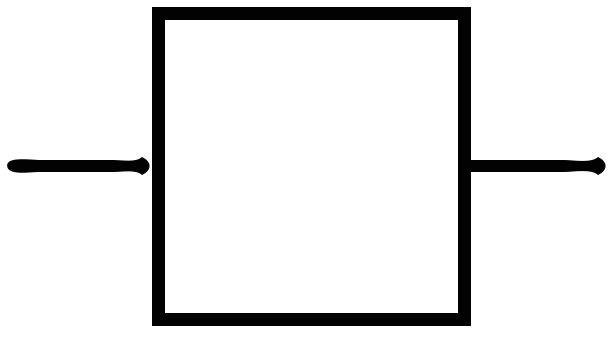

In [107]:
from IPython.core.display import SVG
SVG(filename='statejunction.svg')

## Learning Outcomes

- Demonstrate use of the StateJunction unit model in IDAES
- Demonstrate different options available


## Problem Statement

In this example, we will be passing two different liquid streams through a statejunction. The IDAES StateJunction unit model is a pass-through unit or simple pipe that is primarily used to link streams to/from different process alternatives in conceptual design applications. The inlet conditions are as follows:

**Case 1:**

Molar Flow Rate = 100 mol/s

Temperature = 298.15 K

Pressure = 101325 Pa

Mole Fraction (benzene) = 0.6

Mole Fraction (toluene) = 0.4

**Case 2**

Volumetric Flow Rate = 10 m^3/s

H2O Concentration = 5000 mol/m^3

NaOH Concentration = 25 mol/m^3

Temperature = 298.15 K

Pressure = 101325 Pa 

We will look at two cases in this tutorial:

* Case 1: Use the statejunction unit model to solve a problem with constraints (requires a solver).

* Case 2: Use the statejunction unit model to solve a problem without constraints (does not require a solver).


For more details, please refer to the IDAES documentation: https://idaes-pse.readthedocs.io/en/stable

## Setting up the problem in IDAES

In the following cell, we will be importing the necessary components from Pyomo and IDAES.

In [108]:
# Import objects from pyomo package 
from pyomo.environ import ConcreteModel, Constraint, value, SolverFactory

# Import the solver
from idaes.core.solvers import get_solver

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

# Import the StateJunction unit model
from idaes.models.unit_models import StateJunction

# Import idaes logger to set output levels
import idaes.logger as idaeslog

# Import the modular property package to create a property block for the case 1 flowsheet
from idaes.models.properties.modular_properties.base.generic_property import GenericParameterBlock

# Import the BT_ideal property package to create a configuration file for the GenericParameterBlock based on the ideal eos
from idaes.models.properties.modular_properties.examples.BT_ideal import configuration as configuration

# Import the saponification property package to create a property block for the case 2 flowsheet
from idaes.models.properties.examples.saponification_thermo import SaponificationParameterBlock

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Create the ConcreteModel and the FlowsheetBlock objects, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(dynamic=False) # dynamic or ss flowsheet needs to be specified here

# Add properties parameter block to the case 1 flowsheet with the appropriate configuration file
m.fs.properties_1 = GenericParameterBlock(**configuration)

# Add properties parameter block to the case 2 flowsheet
m.fs.properties_2 = SaponificationParameterBlock()

## Case 1:

In the following cell, we will be creating the StateJunction unit model, assigning the appropriate property packages to it, and determining the degrees of freedom associated with the StateJunction unit model.

In [109]:
# Create an instance of the StateJunction unit, attaching it to the flowsheet
# Specify that the property packages to be used for the inlet and outlet streams are the ones we created earlier

m.fs.statejunction_1 = StateJunction(property_package=m.fs.properties_1)

# Call the degrees_of_freedom function, get initial DOF
DOF_initial = degrees_of_freedom(m)
print('The initial degrees of freedom is: {0}'.format(DOF_initial))

The initial degrees of freedom is: 5


In [110]:
assert DOF_initial == 5

In the following cell, we will be specifying the inlet conditions for the StateJunction block.

In [111]:
# Fix the inlet conditions

m.fs.statejunction_1.inlet.flow_mol.fix(100) # converting to mol/s as unit basis is mol/s
m.fs.statejunction_1.inlet.mole_frac_comp[0, "benzene"].fix(0.6)
m.fs.statejunction_1.inlet.mole_frac_comp[0, "toluene"].fix(0.4)
m.fs.statejunction_1.inlet.pressure.fix(101325) # Pa
m.fs.statejunction_1.inlet.temperature.fix(298.15) # K

# Call the degrees_of_freedom function, get final DOF
DOF_final = degrees_of_freedom(m)
print('The final degrees of freedom is: {0}'.format(DOF_final))

The final degrees of freedom is: 0


In [112]:
assert DOF_final == 0

### Flowsheet Initialization

In [113]:
# Initialize the flowsheet, and set the output at WARNING
m.fs.statejunction_1.initialize(outlvl=idaeslog.WARNING)

### Obtaining Simulation Results

In [ ]:
# Solve the simulation using the IDAES solver
# Note: If the degrees of freedom = 0, we have a square problem
solver = get_solver()
result = solver.solve(m, tee=True)

In [ ]:
from pyomo.opt import TerminationCondition, SolverStatus

# Check if termination condition is optimal
assert result.solver.termination_condition == TerminationCondition.optimal
assert result.solver.status == SolverStatus.ok

### View Results

As expected of a pass-through unit model, the stream composition of the inlet is identical to that of the outlet.

In [ ]:
# Display output report
m.fs.statejunction_1.report()

In [ ]:
import pytest

# Check results
assert value(m.fs.statejunction_1.outlet.flow_mol[0]) == pytest.approx(100, rel=1e-6)
assert value(m.fs.statejunction_1.outlet.pressure[0]) == pytest.approx(101325, rel=1e-6)
assert value(m.fs.statejunction_1.outlet.temperature[0]) == pytest.approx(298.15, rel=1e-6)
assert value(m.fs.statejunction_1.outlet.mole_frac_comp[0,"benzene"]) == pytest.approx(0.6, rel=1e-6)
assert value(m.fs.statejunction_1.outlet.mole_frac_comp[0,"toluene"]) == pytest.approx(0.4, rel=1e-6)

## Case 2:

In the following cell, we will be creating the StateJunction unit model, assigning the appropriate property packages to it, and determining the degrees of freedom associated with the StateJunction unit model.

In [ ]:
# Create an instance of the StateJunction unit, attaching it to the flowsheet
# Specify that the property packages to be used for the inlet and outlet streams are the ones we created earlier

m.fs.statejunction_2 = StateJunction(property_package=m.fs.properties_2)

# Call the degrees_of_freedom function, get initial DOF
DOF_initial = degrees_of_freedom(m)
print('The initial degrees of freedom is: {0}'.format(DOF_initial))

In [ ]:
assert DOF_initial == 0

In the following cell, we will be specifying the inlet conditions for the StateJunction block.

In [ ]:
# Fix the inlet conditions

m.fs.statejunction_2.inlet.flow_vol.fix(10) # m^3/s

m.fs.statejunction_2.inlet.conc_mol_comp[0, "H2O"].fix(5000) # mol/m^3
m.fs.statejunction_2.inlet.conc_mol_comp[0, "NaOH"].fix(25)  # mol/m^3
m.fs.statejunction_2.inlet.conc_mol_comp[0, "EthylAcetate"].fix(50)  # mol/m^3
m.fs.statejunction_2.inlet.conc_mol_comp[0, "SodiumAcetate"].fix(100)  # mol/m^3
m.fs.statejunction_2.inlet.conc_mol_comp[0, "Ethanol"].fix(200)  # mol/m^3

m.fs.statejunction_2.inlet.pressure.fix(101325) # Pa
m.fs.statejunction_2.inlet.temperature.fix(298.15) # K

# Call the degrees_of_freedom function, get final DOF
DOF_final = degrees_of_freedom(m)
print('The final degrees of freedom is: {0}'.format(DOF_final))

In [ ]:
assert DOF_final == 0

### Flowsheet Initialization

In [ ]:
# Initialize the flowsheet, and set the output at WARNING
m.fs.statejunction_2.initialize(outlvl=idaeslog.WARNING)

### View Results

Since this problem has no constraints, a solver is not required to compute the properties of the outlet stream. As the following report will show, the stream composition of the inlet is identical to that of the outlet.

In [ ]:
# Display output report
m.fs.statejunction_2.report()

In [ ]:
import pytest

# Check results
assert value(m.fs.statejunction_2.outlet.flow_vol[0]) == pytest.approx(100, rel=1e-6)
assert value(m.fs.statejunction_2.outlet.pressure[0]) == pytest.approx(101325, rel=1e-6)
assert value(m.fs.statejunction_2.outlet.temperature[0]) == pytest.approx(298.15, rel=1e-6)
assert value(m.fs.statejunction_2.outlet.conc_mol_comp[0,"H2O"]) == pytest.approx(5000, rel=1e-6)
assert value(m.fs.statejunction_2.outlet.conc_mol_comp[0,"NaOH"]) == pytest.approx(25, rel=1e-6)
assert value(m.fs.statejunction_2.outlet.conc_mol_comp[0,"EthylAcetate"]) == pytest.approx(50, rel=1e-6)
assert value(m.fs.statejunction_2.outlet.conc_mol_comp[0,"SodiumAcetate"]) == pytest.approx(100, rel=1e-6)
assert value(m.fs.statejunction_2.outlet.conc_mol_comp[0,"Ethanol"]) == pytest.approx(200, rel=1e-6)